In [1]:
import datajoint as dj
from ibl_pipeline import behavior
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from ibl_pipeline.plotting import plotting_utils_ephys as putils
# from ibl_pipeline.plotting import ephys as ephys_plotting
import pandas as pd
import colorlover as cl
import json
import seaborn as sns
import pdb

Connecting shan@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as vathes


In [2]:
ephys = dj.create_virtual_module('ephys', 'test_ibl_ephys')

In [3]:
def get_sort_and_marker(align_event, sorting_var):

    if sorting_var == 'response - stim on':
        sorting_query = 'trial_response_time - trial_stim_on_time'
        if align_event == 'stim on':
            mark = sorting_query
            label = 'response'
        elif align_event == 'response':
            mark = 'trial_stim_on_time - trial_response_time'
            label = 'stim on'
        else:
            raise NameError(
                f"""
                Wrong combination of alignment and sorting:\n
                {sorting_var}, {align_event}
                """
            )
    elif sorting_var == 'feedback - stim on':
        sorting_query = 'trial_feedback_time - trial_stim_on_time'
        if align_event == 'stim on':
            mark = sorting_query
            label = 'feedback'
        elif align_event == 'feedback':
            mark = 'trial_stim_on_time - trial_feedback_time'
            label = 'stim on'
        else:
            raise NameError(
                f"""
                Wrong combination of alignment and sorting:\n
                {sorting_var}, {align_event}
                """
            )
    elif sorting_var == 'feedback - response':
        sorting_query = 'trial_feedback_time - trial_response_time'
        if align_event == 'response':
            mark = sorting_query
            label = 'feedback'
        elif align_event == 'feedback':
            mark = 'trial_response_time - trial_feedback_time'
            label = 'response'
        else:
            raise NameError(
                f"""
                Wrong combination of alignment and sorting:\n
                {sorting_var}, {align_event}
                """
            )
    elif sorting_var == 'contrast':
        sorting_query = 'trial_signed_contrast, trial_id'
        mark = None
        label = None
    elif sorting_var == 'feedback type':
        sorting_query = 'feedback type, trial_id'
        mark = None
        label = None
    elif sorting_var == 'trial_id':
        sorting_query = 'trial_id'
        mark = None
        label = None
    else:
        raise NameError("""
            'Unknown sorting variable.\n
            It has to be one of the following:\n
            ["trial_id", \n
             "response - stim on", \n
             "feedback - stim on", \n
             "feedback - response",
             "contrast"]'""")
    return sorting_query, mark, label

In [18]:
def get_spike_times(trials, sorting_var, align_event,
                    sort_by=None,
                    mark=None):
    if sorting_var != 'trial_id':
        trials = (trials & 'event="{}"'.format(align_event)).proj(
            'trial_id', 'trial_spike_times', sort_by=sort_by, mark=mark)
        spk_times, marking_points = trials.fetch(
            'trial_spike_times', 'mark', order_by='sort_by')
    else:
        trials = (trials & 'event="{}"'.format(align_event)).proj(
            'trial_id', 'trial_spike_times', sort_by=sort_by)
        spk_times = trials.fetch(
            'trial_spike_times', order_by='sort_by')
        marking_points = None

    return spk_times, marking_points


def get_spike_times_trials(trials, sorting_var, align_event,
                           sort_by=None,
                           mark=None):

    trials_left = trials & 'trial_response_choice="CW"' & \
        'trial_signed_contrast < 0'
    trials_right = trials & 'trial_response_choice="CCW"' & \
        'trial_signed_contrast > 0'

    trials_incorrect = trials - trials_left.proj() - trials_right.proj()

    kargs = dict(
        sorting_var=sorting_var,
        align_event=align_event,
        sort_by=sort_by,
        mark=mark
    )

    spk_times_left, marking_points_left = get_spike_times(trials_left, **kargs)
    spk_times_right, marking_points_right = get_spike_times(trials_right, **kargs)
    spk_times_incorrect, marking_points_incorrect = \
        get_spike_times(trials_incorrect, **kargs)

    return spk_times_left, \
        marking_points_left, \
        spk_times_right, \
        marking_points_right, \
        spk_times_incorrect, \
        marking_points_incorrect


def create_raster_plot_combined(trials, align_event,
                                sorting_var='trial_id',
                                x_lim=[-1, 1],
                                fig_dir=None,
                                store_type=None,
                                show_plot=False):

    sorting_query, mark, label = get_sort_and_marker(
        align_event, sorting_var)

    fig = plt.figure(dpi=150, frameon=False, figsize=[10, 5])
    ax = plt.Axes(fig, [0., 0., 1., 1.])

    if len(trials):
        if sorting_var == 'trial_id':
            spk_times, trial_ids = (trials & 'event="{}"'.format(align_event)).fetch(
                'trial_spike_times', 'trial_id', order_by='trial_id')
            spk_trial_ids = np.hstack(
                [[trial_id] * len(spk_time)
                    for trial_id, spk_time in enumerate(spk_times)])
            ax.plot(np.hstack(spk_times), spk_trial_ids, 'k.', alpha=0.5,
                    markeredgewidth=0)
        elif sorting_var == 'contrast':
            spk_times, trial_contrasts = (trials & 'event="{}"'.format(align_event)).fetch(
                'trial_spike_times', 'trial_signed_contrast',
                order_by='trial_signed_contrast, trial_id')
            spk_trial_ids = np.hstack(
                [[trial_id] * len(spk_time)
                    for trial_id, spk_time in enumerate(spk_times)])
            ax.plot(np.hstack(spk_times), spk_trial_ids, 'k.', alpha=0.5,
                    markeredgewidth=0)
            
            # plot different contrasts as background
            contrasts, u_inds = np.unique(trial_contrasts, return_index=True)
            u_inds = list(u_inds) + [len(trial_contrasts)]
            
            tick_positions = np.add(u_inds[1:], u_inds[:-1])/2
            
            puor = cl.scales[str(len(contrasts))]['div']['PuOr']
            puor = np.divide(cl.to_numeric(puor), 255)

            for i, ind in enumerate(u_inds[:-1]):
                ax.fill_between([-1, 1], u_inds[i], u_inds[i+1]-1, color=puor[i], alpha=0.8)
            fig.add_axes(ax)
        elif sorting_var == 'feedback type':
            spk_times, trial_fb_types = (trials & 'event="{}"'.format(align_event)).fetch(
                'trial_spike_times', 'trial_feedback_type',
                order_by='trial_feedback_type, trial_id')
            spk_trial_ids = np.hstack(
                [[trial_id] * len(spk_time)
                    for trial_id, spk_time in enumerate(spk_times)])
            ax.plot(np.hstack(spk_times), spk_trial_ids, 'k.', alpha=0.5,
                    markeredgewidth=0)

            # plot different feedback types as background
            fb_types, u_inds = np.unique(trial_fb_types, return_index=True)
            u_inds = list(u_inds) + [len(trial_fb_types)]

            colors = sns.diverging_palette(10, 240, n=len(fb_types))

            for i, ind in enumerate(u_inds[:-1]):
                ax.fill_between([-1, 1], u_inds[i], u_inds[i+1]-1, color=colors[i], alpha=0.5)
            fig.add_axes(ax)
        else:
            spk_times_left, marking_points_left, \
                spk_times_right, marking_points_right, \
                spk_times_incorrect, marking_points_incorrect = \
                get_spike_times_trials(
                    trials, sorting_var, align_event, sorting_query, mark)

            id_gap = len(trials) * 0.02

            if len(spk_times_incorrect):
                spk_times_all_incorrect = np.hstack(spk_times_incorrect)
                id_incorrect = [[i] * len(spike_time)
                                for i, spike_time in
                                enumerate(spk_times_incorrect)]
                id_incorrect = np.hstack(id_incorrect)
                ax.plot(spk_times_all_incorrect, id_incorrect, 'r.',
                        alpha=0.5, markeredgewidth=0, label='incorrect trials')
                ax.plot(marking_points_incorrect,
                        range(len(spk_times_incorrect)), 'r', label=label)
            else:
                id_incorrect = [0]

            if not len(id_incorrect):
                id_incorrect = [0]

            if len(spk_times_left):
                spk_times_all_left = np.hstack(spk_times_left)
                id_left = [[i + max(id_incorrect) + id_gap] * len(spike_time)
                           for i, spike_time in
                           enumerate(spk_times_left)]
                id_left = np.hstack(id_left)
                ax.plot(spk_times_all_left, id_left, 'g.',
                        alpha=0.5, markeredgewidth=0, label='left trials')
                ax.plot(marking_points_left,
                        np.add(range(len(spk_times_left)), max(id_incorrect) + id_gap), 'g')
            else:
                id_left = [max(id_incorrect)]

            if not len(id_left):
                id_left = [max(id_incorrect)]

            if len(spk_times_right):
                spk_times_all_right = np.hstack(spk_times_right)
                id_right = [[i + max(id_left) + id_gap] * len(spike_time)
                            for i, spike_time in enumerate(spk_times_right)]
                id_right = np.hstack(id_right)

                ax.plot(spk_times_all_right, id_right, 'b.',
                        alpha=0.5, markeredgewidth=0, label='right trials')
                ax.plot(marking_points_right,
                        np.add(range(len(spk_times_right)), max(id_left) + id_gap), 'b')
            else:
                id_right = [max(id_left)]

            if not len(id_right):
                id_right = [max(id_left)]

    ax.set_axis_off()
    fig.add_axes(ax)

    # hide the axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # set the limits
    ax.set_xlim(x_lim[0], x_lim[1])
    if sorting_var in ('trial_id', 'contrast', 'feedback type'):
        if len(spk_trial_ids):
            y_lim = max(spk_trial_ids) * 1.02
        else:
            y_lim = 2
    else:
        y_lim = max(id_right) * 1.02
    ax.set_ylim(-2, y_lim)

    if not show_plot:
        plt.close(fig)

    # save the figure with `pad_inches=0` to remove
    # any padding in the image

    if fig_dir:
        if store_type == 'filepath':
            if not os.path.exists(os.path.dirname(fig_dir)):
                try:
                    os.makedirs(os.path.dirname(fig_dir))
                except OSError as exc:  # Guard against race condition
                    if exc.errno != errno.EEXIST:
                        raise
            fig.savefig(fig_dir, pad_inches=0)
            
            if sorting_var == 'contrast':
                return [0, y_lim], label, contrasts, tick_positions
            else:
                return [0, y_lim], label

        elif store_type == 's3':
            access, secret = (ibl_pipeline.S3Access & 's3_id=1').fetch1(
                'access_key', 'secret_key')

            s3 = boto3.resource(
                's3',
                aws_access_key_id=access,
                aws_secret_access_key=secret)
            BUCKET_NAME = "ibl-dj-external"
            bucket = s3.Bucket(BUCKET_NAME)

            # upload to s3
            img_data = io.BytesIO()
            fig.savefig(img_data, format='png')
            img_data.seek(0)
            bucket.put_object(Body=img_data,
                              ContentType='image/png',
                              Key=fig_dir)
            
            if sorting_var == 'contrast':
                return [0, y_lim], label, contrasts, tick_positions
            else:
                return [0, y_lim], label

    else:
        import tempfile
        temp = tempfile.NamedTemporaryFile(suffix=".png")
        fig.savefig(temp.name, pad_inches=0)
        import base64
        with open(temp.name, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read())
        temp.close()
        
        if sorting_var == 'contrast':
            return encoded_string, [0, y_lim], label, contrasts, tick_positions
        else:
            return encoded_string, [0, y_lim], label

In [4]:
# create some plots for the legend
def get_legend(trials_type, legend_group):
    if trials_type == 'left':
        color = 'green'
    elif trials_type == 'right':
        color = 'blue'
    elif trials_type == 'incorrect':
        color = 'red'
    else:
        raise NameError(
            f"""
            Wrong trial type, has to be one of the following: \n
            "left", "right", "incorrect"
            """
        )
    if legend_group == 'spike':
        marker = 'markers'
    else:
        marker = 'lines'
      
    return go.Scatter(
        x=[5],
        y=[10],
        mode=marker,
        marker=dict(
            size=6,
            color=color,
            opacity=0.5
        ),
        name='{} time on<br>{} trials'.format(legend_group, trials_type),
        legendgroup=legend_group
    )


In [5]:
from ibl_pipeline import subject
keys = (ephys.DefaultCluster & (subject.Subject & 'subject_nickname="CSHL047"')).fetch('KEY')
key = keys[30]

In [6]:
from uuid import UUID
import datetime
key = {'subject_uuid': UUID('15f98ab5-20d8-4345-a5de-21912a39575f'),
   'session_start_time': datetime.datetime(2020, 1, 22, 8, 28, 49),
   'probe_idx': 1,
   'cluster_id': 35}

/src/IBL-pipeline/ibl_pipeline/plotting/plotting_utils_ephys.py:546: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



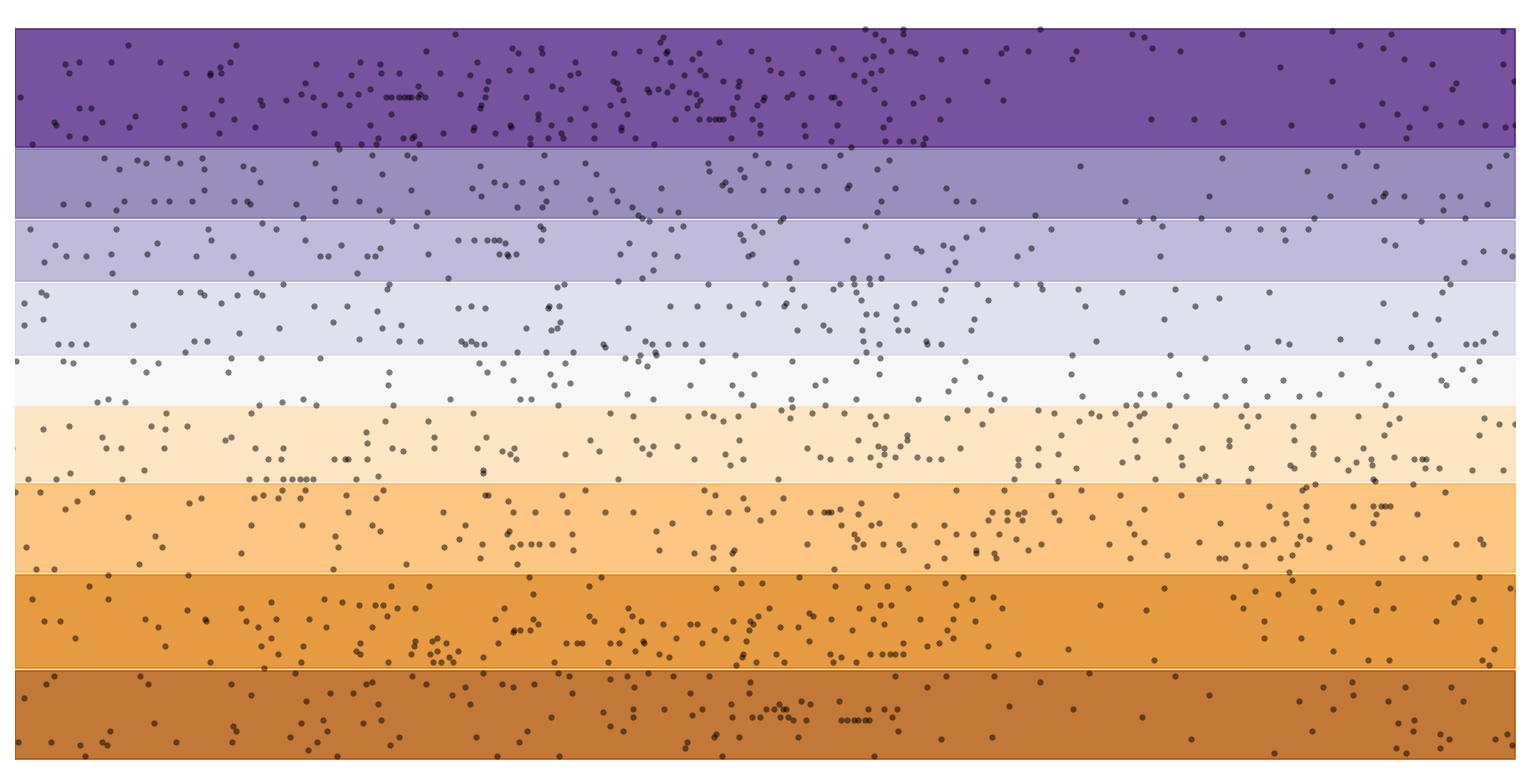

In [17]:
# new cluster
cluster = ephys.DefaultCluster & key
trials_all = (behavior.TrialSet.Trial * ephys.AlignedTrialSpikes & cluster).proj(
    'trial_start_time', 'trial_stim_on_time', 'trial_response_time', 'trial_feedback_time',
    'trial_response_choice', 'trial_spike_times', 'trial_feedback_type',
    trial_duration='trial_end_time-trial_start_time',
    trial_signed_contrast='trial_stim_contrast_right - trial_stim_contrast_left'
) & 'trial_duration < 5' & 'trial_response_choice!="No Go"' & key

trials_left = trials_all & 'trial_response_choice="CW"' & 'trial_signed_contrast < 0'
trials_right = trials_all & 'trial_response_choice="CCW"' & 'trial_signed_contrast > 0'
trials = trials_all & [trials_right.proj(), trials_left.proj()]
align_event = 'stim on'
encoded_string, y_lim, label, contrasts, tick_pos = putils.create_raster_plot_combined(
    trials_all, align_event, 'contrast', show_plot=True)
# encoded_string, y_lim, label = putils.create_raster_plot_combined(
#     trials_all, align_event, 'feedback type', show_plot=True)

In [15]:
len(trials_left)

184

# Feedback type

In [12]:
x_lim=[-1, 1]
# axis = go.Scatter(
#     x=x_lim,
#     y=y_lim,
#     mode='markers',
#     marker=dict(opacity=0),
#     showlegend=False,
#     yaxis='y2'
# )

axis = go.Scatter(
    x=x_lim,
    y=y_lim,
    mode='markers',
    marker=dict(opacity=0),
    showlegend=False,
)

incorrect = go.Scatter(
    x=[-2, -1],
    y=[-2, -1],
    fill='tozeroy',
    fillcolor='rgba(218, 59, 70, 0.5)',
    name='Incorrect',
    mode= 'none'
)
correct = go.Scatter(
    x=[-2, -1],
    y=[-2, -1],
    fill='tonexty',
    fillcolor='rgba(65, 124, 168, 0.5)',
    name='Correct',
    mode= 'none'
)


legend_left = putils.get_legend('left', 'spike')
legend_right = putils.get_legend('right', 'spike')
legend_incorrect = putils.get_legend('incorrect', 'spike')

legend_mark_left = putils.get_legend('left', label)
legend_mark_right = putils.get_legend('right', label)
legend_mark_incorrect = putils.get_legend('incorrect', label)

layout = go.Layout(
    images=[dict(
      source='data:image/png;base64, ' + encoded_string.decode(),
      sizex=x_lim[1] - x_lim[0],
      sizey=y_lim[1] - y_lim[0],
      x=x_lim[0],
      y=y_lim[1],
      xref='x',
      yref='y',
      sizing='stretch',
      layer='below'
    )],
    width=580,
    height=370,
    margin=go.layout.Margin(
        l=50,
        r=30,
        b=40,
        t=80,
        pad=0
    ),
    title=dict(
        text='Raster, aligned to {}'.format(align_event),
        x = 0.21,
        y=0.87
    ),
    xaxis=dict(
        title='Time (sec)',
        range=x_lim,
        showgrid=False
    ), 
    yaxis=dict(
        title='Trial idx',
        range=y_lim,
        showgrid=False
    ),
     
)

data = [axis, incorrect, correct]
#         legend_mark_left, legend_mark_right, legend_mark_incorrect]

fig = go.Figure(data=data, layout=layout)

# fig.update_layout(
#     yaxis2=dict(
#         title='Contrast',
#         range=y_lim,
#         showgrid=False,
#         overlaying='y',
#         side='right',
#         tickmode='array',
#         tickvals=list(tick_pos),
#         ticktext=list(contrasts)
#     ))

plotly.offline.iplot(fig)

In [58]:
f = open("rasters_contrast.json","w")
s = json.dumps(fig.to_plotly_json())
f.write(s)
f.close()

# Contrast

In [18]:
x_lim=[-1, 1]
axis2 = go.Scatter(
    x=x_lim,
    y=y_lim,
    mode='markers',
    marker=dict(opacity=0),
    showlegend=False,
    yaxis='y2'
)

layout = go.Layout(
    images=[dict(
      source='data:image/png;base64, ' + encoded_string.decode(),
      sizex=x_lim[1] - x_lim[0],
      sizey=y_lim[1] - y_lim[0],
      x=x_lim[0],
      y=y_lim[1],
      xref='x',
      yref='y',
      sizing='stretch',
      layer='below'
    )],
    width=580,
    height=370,
    margin=go.layout.Margin(
        l=50,
        r=30,
        b=40,
        t=80,
        pad=0
    ),
    title=dict(
        text='Raster, aligned to {}'.format(align_event),
        x = 0.21,
        y=0.87
    ),
    xaxis=dict(
        title='Time (sec)',
        range=x_lim,
        showgrid=False
    ), 
    yaxis=dict(
        title='Trial idx',
        range=y_lim,
        showgrid=False
    ),
     
)

data = [axis2]
fig = go.Figure(data=data, layout=layout)

fig.update_layout(
    yaxis2=dict(
        title='Contrast',
        range=y_lim,
        showgrid=False,
        overlaying='y',
        side='right',
        tickmode='array',
        tickvals=list(tick_pos),
        ticktext=list(contrasts)
    ))

plotly.offline.iplot(fig)